## Without Time Data

Using device: cuda


,40m Wind Speed [m/s],60m Wind Speed [m/s],70m Wind Speed [m/s],80m Wind Speed [m/s],87m Wind Speed [m/s],100m Wind Speed [m/s],107m Wind Speed [m/s]
0,3.45,3.48,3.62,3.84,3.92,3.83,3.72
1,3.14,3.16,3.28,3.46,3.59,3.53,3.44
2,3.65,3.67,3.78,3.89,3.93,3.88,3.80
3,3.86,3.88,3.96,4.03,4.06,4.00,3.97
4,3.60,3.60,3.66,3.73,3.76,3.73,3.69



Data shape: (56877, 7)


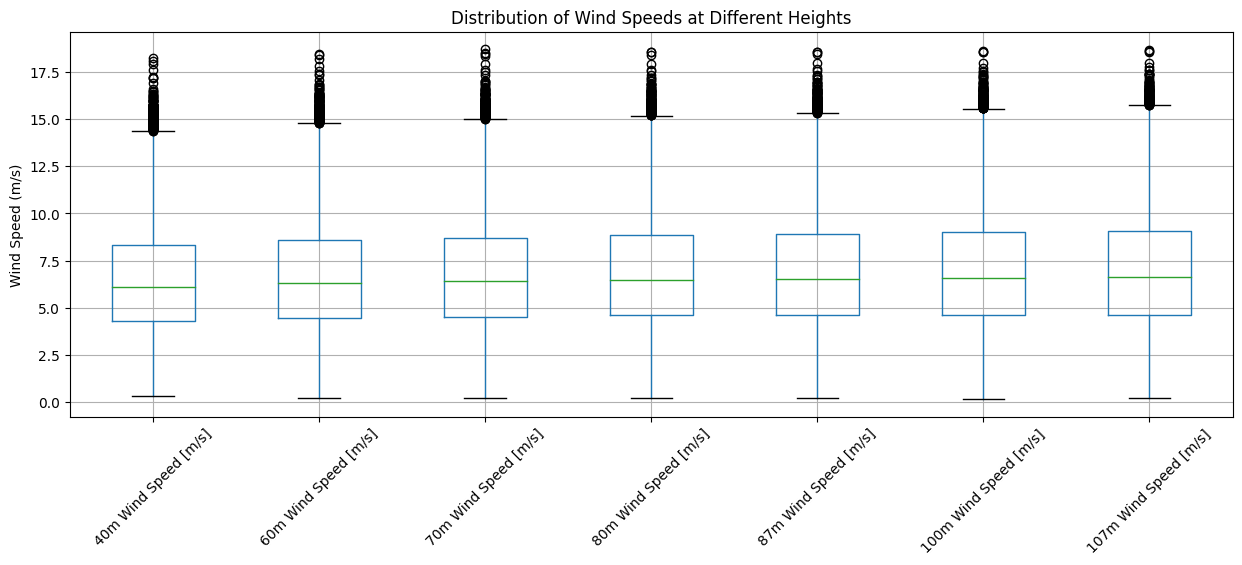

NaN values in data: 115744
Infinite values in data: 0


Sparrow Search Progress:   0%|          | 0/5 [00:00<?, ?it/s]

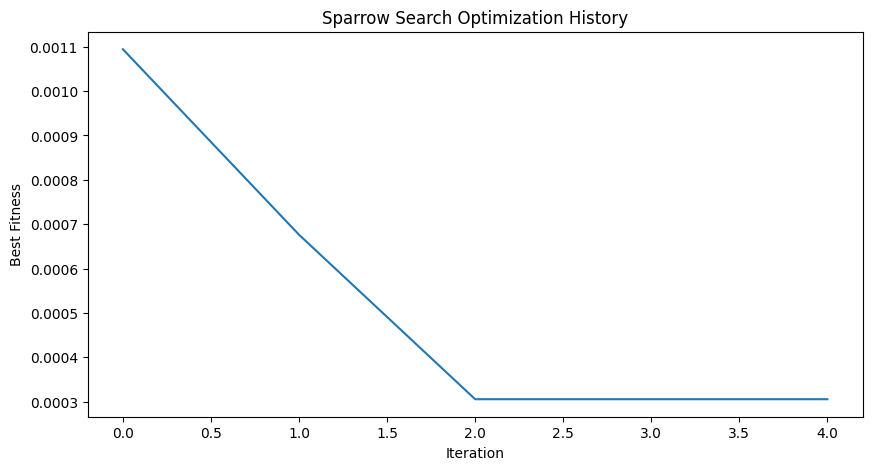


Best parameters found: {'hidden_size': 37, 'num_layers': 2, 'dropout': 0.4958093402546381, 'learning_rate': 0.0017195360220613267}
Best fitness: 0.00030552599020345895

Training vanilla LSTM...

Training optimized LSTM...

Vanilla LSTM Metrics:


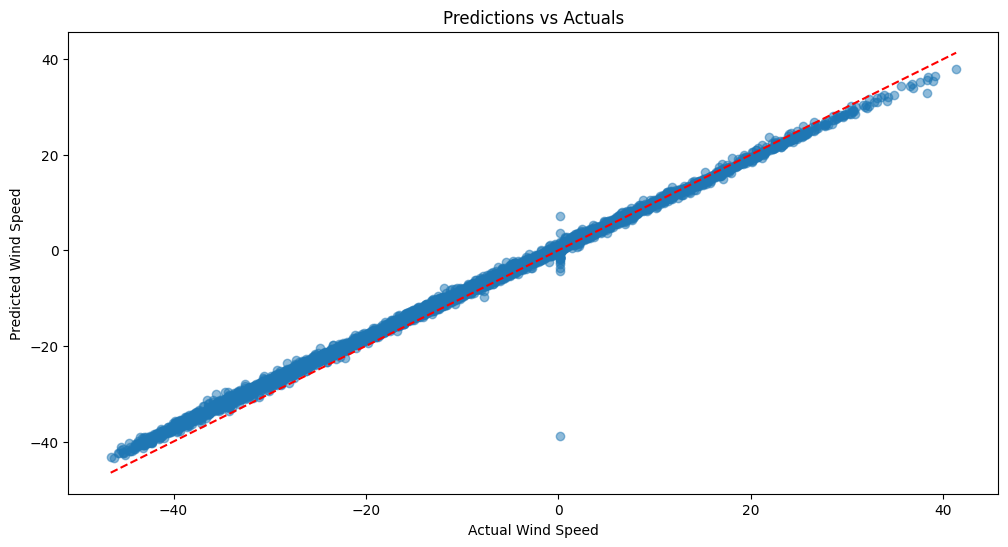

mse: 3.1077
mae: 1.4653
rmse: 1.7629
r2: 0.9855

Optimized LSTM Metrics:


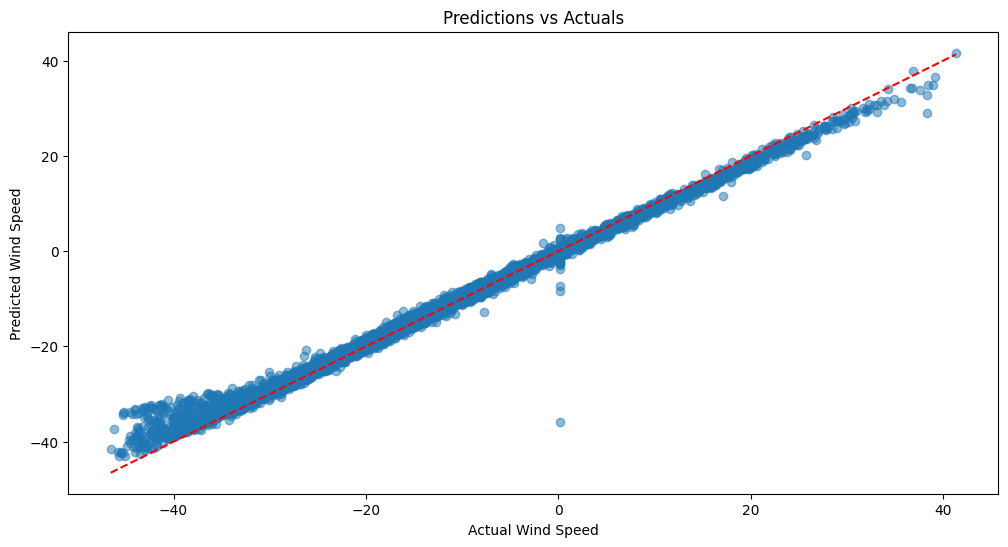

mse: 1.8509
mae: 0.8116
rmse: 1.3605
r2: 0.9913


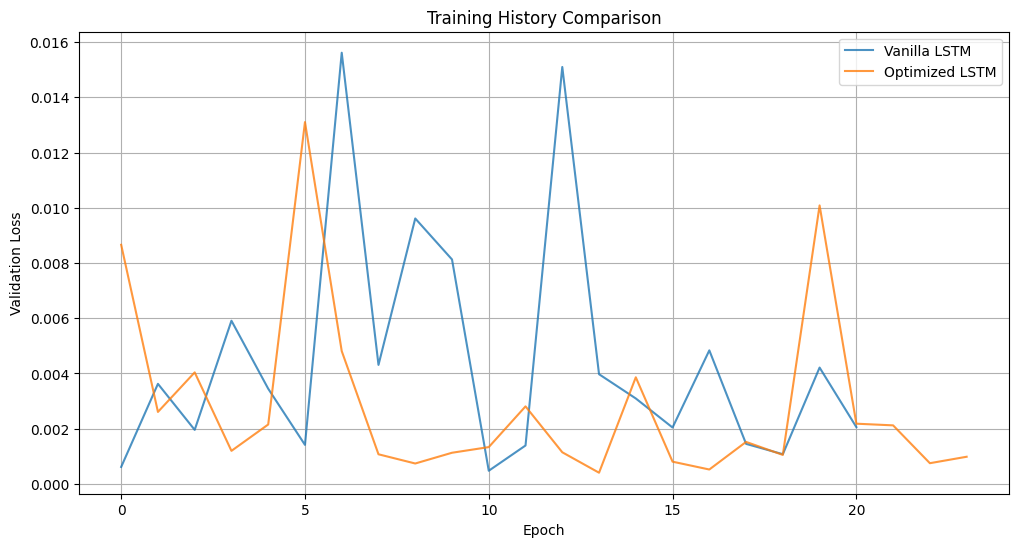

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict
import random
from torch.cuda.amp import autocast, GradScaler
import logging
from IPython.display import display, HTML
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
def set_seeds(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seeds(42)

# Configuration
CONFIG = {
    'input_size': 6,  # Number of input features
    'sequence_length': 10,  # Number of time steps to look back
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 100,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'train_size': 0.7,  # Added train size
    'val_size': 0.15,   # Added validation size
    'test_size': 0.15   # Added test size
}

print(f"Using device: {CONFIG['device']}")

class WindSpeedDataset(Dataset):
    def __init__(self, data: np.ndarray, sequence_length: int):
        self.data = torch.FloatTensor(data)
        self.sequence_length = sequence_length
        
    def __len__(self) -> int:
        return len(self.data) - self.sequence_length
        
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.data[idx:idx + self.sequence_length, :-1]
        y = self.data[idx + self.sequence_length - 1, -1]
        return x, y

def preprocess_data(data: pd.DataFrame) -> Tuple[np.ndarray, MinMaxScaler]:
    """
    Preprocess the data with both scaling and statistical normalization
    """
    # Check for NaN or infinite values
    if data.isna().any().any() or np.isinf(data.values).any():
        logger.warning("Found NaN or infinite values in the data. Replacing with mean values.")
        data = data.fillna(data.mean())
        
        # Replace inf values column-wise
        for col in data.columns:
            mean_value = data[col].mean()  # Compute column mean
            data[col] = data[col].replace([np.inf, -np.inf], mean_value)
    
    # First apply MinMax scaling
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Apply statistical normalization
    mean = np.mean(scaled_data, axis=0)
    std = np.std(scaled_data, axis=0)
    normalized_data = (scaled_data - mean) / (std + 1e-8)
    
    return normalized_data, scaler

class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Add batch normalization for input
        self.input_bn = nn.BatchNorm1d(input_size)
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Add batch normalization after LSTM
        self.hidden_bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
        
        # Initialize weights properly
        self._init_weights()
        
    # def _init_weights(self):
    #     for name, param in self.named_parameters():
    #         if 'weight' in name:
    #             nn.init.xavier_normal_(param)
    #         elif 'bias' in name:
    #             nn.init.constant_(param, 0.0)
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() > 1:  # Apply Xavier only to weight matrices
                nn.init.xavier_normal_(param)
            elif 'bias' in name:  # Bias initialization remains unchanged
                nn.init.constant_(param, 0.0)

                
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Add gradient clipping for stability
        for param in self.parameters():
            if param.grad is not None:
                torch.nn.utils.clip_grad_norm_(param, max_norm=1.0)
                
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # Apply input batch normalization
        x_reshaped = x.view(-1, x.size(-1))
        x_bn = self.input_bn(x_reshaped)
        x = x_bn.view(batch_size, seq_len, -1)
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # Apply LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Apply batch normalization on the output features
        last_output = out[:, -1, :]
        normalized_output = self.hidden_bn(last_output)
        
        # Apply final linear layer
        out = self.fc(normalized_output)
        
        return out.squeeze()

class SparrowSearch:
    def __init__(self, n_particles: int, max_iter: int, param_bounds: Dict):
        self.n_particles = n_particles
        self.max_iter = max_iter
        self.param_bounds = param_bounds
        self.best_solution = None
        self.best_fitness = float('inf')
        self.history = []
        
        # Initialize best_solution with middle values from param bounds
        self.best_solution = {}
        for param, (low, high) in self.param_bounds.items():
            if isinstance(low, int) and isinstance(high, int):
                self.best_solution[param] = (low + high) // 2
            else:
                self.best_solution[param] = (low + high) / 2
                
    def initialize_population(self) -> List[Dict]:
        population = []
        for i in range(self.n_particles):
            particle = {}
            for param, (low, high) in self.param_bounds.items():
                if isinstance(low, int) and isinstance(high, int):
                    particle[param] = random.randint(low, high)
                else:
                    particle[param] = random.uniform(low, high)
            population.append(particle)
        return population
        
    def update_position(self, particle: Dict, r2: float, alarm_value: float) -> Dict:
        new_particle = particle.copy()
        for param, (low, high) in self.param_bounds.items():
            if random.random() < alarm_value:
                # Random exploration
                if isinstance(low, int) and isinstance(high, int):
                    new_particle[param] = random.randint(low, high)
                else:
                    new_particle[param] = random.uniform(low, high)
            else:
                # Move towards best solution
                step = r2 * (self.best_solution[param] - particle[param])
                new_value = particle[param] + step
                if isinstance(low, int) and isinstance(high, int):
                    new_value = int(round(new_value))
                new_particle[param] = max(low, min(high, new_value))
        return new_particle
        
    def optimize(self, fitness_func) -> Tuple[Dict, float]:
        population = self.initialize_population()
        self.history = []
        
        # Add tqdm progress bar
        pbar = tqdm(range(self.max_iter), desc='Sparrow Search Progress')
        
        for iteration in pbar:
            alarm_value = 0.5 - (0.5 * iteration / self.max_iter)
            
            # Evaluate fitness for each particle in population
            iteration_best_fitness = float('inf')
            iteration_best_particle = None
            
            for i, particle in enumerate(population):
                fitness = fitness_func(particle)
                
                # Skip if fitness is NaN and keep the old particle
                if np.isnan(fitness):
                    logger.warning(f"NaN fitness detected for particle {i}. Skipping update.")
                    continue
                
                # Update iteration best
                if fitness < iteration_best_fitness:
                    iteration_best_fitness = fitness
                    iteration_best_particle = particle.copy()
                
                # Update global best
                if fitness < self.best_fitness:
                    self.best_fitness = fitness
                    self.best_solution = particle.copy()
                    pbar.set_postfix({'Best Fitness': f'{self.best_fitness:.6f}'})
            
            # Update population positions based on current best
            if iteration_best_particle is not None:
                r2 = random.random()
                population = [self.update_position(p, r2, alarm_value) for p in population]
                self.history.append(self.best_fitness)
                logger.info(f"Iteration {iteration + 1}/{self.max_iter}, Best fitness: {self.best_fitness:.6f}")
            else:
                logger.warning(f"No valid fitness found in iteration {iteration + 1}. Skipping position updates.")
                
        # Plot optimization history
        if self.history:
            plt.figure(figsize=(10, 5))
            plt.plot(self.history)
            plt.title('Sparrow Search Optimization History')
            plt.xlabel('Iteration')
            plt.ylabel('Best Fitness')
            plt.show()
            
        return self.best_solution, self.best_fitness

def create_train_val_test_split(
    scaled_data: np.ndarray,
    sequence_length: int,
    batch_size: int,
    train_size: float = 0.7,
    val_size: float = 0.15
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Split the data into training, validation, and test sets
    """
    # Calculate sizes
    n = len(scaled_data)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    
    # Split the data
    train_data = scaled_data[:train_end]
    val_data = scaled_data[train_end:val_end]
    test_data = scaled_data[val_end:]
    
    # Create datasets
    train_dataset = WindSpeedDataset(train_data, sequence_length)
    val_dataset = WindSpeedDataset(val_data, sequence_length)
    test_dataset = WindSpeedDataset(test_data, sequence_length)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    logger.info(f"Data split: Train {len(train_dataset)}, Validation {len(val_dataset)}, Test {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader

def train_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str,
    scaler: GradScaler
) -> float:
    """Train for one epoch and return average loss"""
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch_x, batch_y in data_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass with mixed precision
        with autocast():
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            # Skip batch if loss is NaN
            if torch.isnan(loss):
                logger.warning("NaN loss detected during training. Skipping batch.")
                continue
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        
        # Clip gradients for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights with scaler
        scaler.step(optimizer)
        scaler.update()
        
        # Accumulate loss
        total_loss += loss.item()
        num_batches += 1
    
    # Return average loss
    return total_loss / max(num_batches, 1)

def validate(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    device: str
) -> float:
    """Validate model and return average loss"""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            # Skip batch if loss is NaN
            if torch.isnan(loss):
                logger.warning("NaN loss detected during validation. Skipping batch.")
                continue
                
            total_loss += loss.item()
            num_batches += 1
    
    # Return average loss
    return total_loss / max(num_batches, 1)

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str,
    epochs: int,
    early_stopping_patience: int = 10
) -> Dict[str, List[float]]:
    """Train model with early stopping"""
    model = model.to(device)
    scaler = GradScaler()
    history = {'train_loss': [], 'val_loss': []}
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Train one epoch
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        
        # Validate
        val_loss = validate(model, val_loader, criterion, device)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Check for NaN loss
        if np.isnan(train_loss) or np.isnan(val_loss):
            logger.warning(f"NaN loss detected at epoch {epoch+1}. "
                          f"Train loss: {train_loss}, Val loss: {val_loss}")
            
            # Reset optimizer state and adjust learning rate
            optimizer = torch.optim.Adam(
                model.parameters(), 
                lr=optimizer.param_groups[0]['lr'] * 0.5
            )
            continue
        
        # Log progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            logger.info(f"Epoch [{epoch+1}/{epochs}], "
                      f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                logger.info(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    return history

def fitness_function(params, train_loader, val_loader):
    """Fitness function for Sparrow Search optimization"""
    logger.info(f"Evaluating parameters: {params}")
    
    try:
        # Initialize model with parameters
        model = LSTM(
            input_size=CONFIG['input_size'],
            hidden_size=int(params['hidden_size']),
            num_layers=int(params['num_layers']),
            dropout=params['dropout']
        ).to(CONFIG['device'])
        
        # Initialize optimizer and criterion
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        criterion = nn.MSELoss()
        
        # Do a quick evaluation with 5 epochs
        history = train_model(
            model, train_loader, val_loader,
            criterion, optimizer,
            CONFIG['device'], epochs=5
        )
        
        # Get final validation loss
        final_loss = history['val_loss'][-1]
        
        # Check for NaN or infinite loss
        if np.isnan(final_loss) or np.isinf(final_loss):
            logger.warning(f"Invalid loss value: {final_loss}. Returning high penalty.")
            return 1e6
        
        logger.info(f"Evaluation complete. Loss: {final_loss:.6f}")
        return final_loss
        
    except Exception as e:
        logger.error(f"Error in fitness evaluation: {str(e)}")
        return 1e6

def evaluate_model(
    model: nn.Module,
    data_loader: DataLoader,
    target_scaler: MinMaxScaler,
    target_idx: int,
    device: str
) -> Dict[str, float]:
    """Evaluate model on test set and return metrics"""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())
    
    # Create dummy arrays for inverse transform
    pred_dummy = np.zeros((len(predictions), target_scaler.scale_.shape[0]))
    actual_dummy = np.zeros((len(actuals), target_scaler.scale_.shape[0]))
    
    # Set target column
    pred_dummy[:, target_idx] = np.array(predictions).flatten()
    actual_dummy[:, target_idx] = np.array(actuals).flatten()
    
    # Inverse transform
    pred_transformed = target_scaler.inverse_transform(pred_dummy)[:, target_idx]
    actual_transformed = target_scaler.inverse_transform(actual_dummy)[:, target_idx]
    
    # Calculate metrics
    metrics = {
        'mse': mean_squared_error(actual_transformed, pred_transformed),
        'mae': mean_absolute_error(actual_transformed, pred_transformed),
        'rmse': np.sqrt(mean_squared_error(actual_transformed, pred_transformed)),
        'r2': r2_score(actual_transformed, pred_transformed)
    }
    
    # Plot predictions vs actuals
    plt.figure(figsize=(12, 6))
    plt.scatter(actual_transformed, pred_transformed, alpha=0.5)
    plt.plot([min(actual_transformed), max(actual_transformed)], 
             [min(actual_transformed), max(actual_transformed)], 'r--')
    plt.xlabel('Actual Wind Speed')
    plt.ylabel('Predicted Wind Speed')
    plt.title('Predictions vs Actuals')
    plt.show()
    
    return metrics

def run_wind_speed_modeling():
    """Main function to run the wind speed modeling pipeline"""
    # Load data
    data = pd.read_csv('/kaggle/input/data-ws-extrapolation/data.csv')
    display(data.head())
    print("\nData shape:", data.shape)
    
    # Plot input features distribution
    plt.figure(figsize=(15, 5))
    data.boxplot()
    plt.title('Distribution of Wind Speeds at Different Heights')
    plt.ylabel('Wind Speed (m/s)')
    plt.xticks(rotation=45)
    plt.show()
    
    # Check for NaN or infinite values
    print("NaN values in data:", data.isna().sum().sum())
    print("Infinite values in data:", np.isinf(data.values).sum())
    
    # Preprocess data
    scaled_data, scaler = preprocess_data(data)
    
    # Create train, validation, and test splits
    train_loader, val_loader, test_loader = create_train_val_test_split(
        scaled_data,
        CONFIG['sequence_length'],
        CONFIG['batch_size'],
        CONFIG['train_size'],
        CONFIG['val_size']
    )
    
    # Define parameter bounds for Sparrow Search
    param_bounds = {
        'hidden_size': (32, 128),
        'num_layers': (1, 3),
        'dropout': (0.1, 0.5),
        'learning_rate': (0.0005, 0.005)
    }
    
    # Create fitness function with fixed train/val loaders
    def search_fitness(params):
        return fitness_function(params, train_loader, val_loader)
    
    # Initialize and run Sparrow Search
    sparrow = SparrowSearch(n_particles=5, max_iter=5, param_bounds=param_bounds)
    best_params, best_fitness = sparrow.optimize(search_fitness)
    
    print("\nBest parameters found:", best_params)
    print("Best fitness:", best_fitness)
    
    # Train vanilla LSTM
    vanilla_lstm = LSTM(
        input_size=CONFIG['input_size'],
        hidden_size=64,
        num_layers=2,
        dropout=0.2
    )
    
    vanilla_optimizer = torch.optim.Adam(vanilla_lstm.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    print("\nTraining vanilla LSTM...")
    vanilla_history = train_model(
        vanilla_lstm, train_loader, val_loader,
        criterion, vanilla_optimizer,
        CONFIG['device'], CONFIG['epochs']
    )
    
    # Train optimized LSTM
    optimized_lstm = LSTM(
        input_size=CONFIG['input_size'],
        hidden_size=int(best_params['hidden_size']),
        num_layers=int(best_params['num_layers']),
        dropout=best_params['dropout']
    )
    
    optimized_optimizer = torch.optim.Adam(
        optimized_lstm.parameters(),
        lr=best_params['learning_rate']
    )
    
    print("\nTraining optimized LSTM...")
    optimized_history = train_model(
        optimized_lstm, train_loader, val_loader,
        criterion, optimized_optimizer,
        CONFIG['device'], CONFIG['epochs']
    )
    
    # Evaluate models on test set
    target_idx = -1  # Assuming the target is the last column
    
    print("\nVanilla LSTM Metrics:")
    vanilla_metrics = evaluate_model(
        vanilla_lstm, test_loader, scaler, target_idx, CONFIG['device']
    )
    for metric, value in vanilla_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nOptimized LSTM Metrics:")
    optimized_metrics = evaluate_model(
        optimized_lstm, test_loader, scaler, target_idx, CONFIG['device']
    )
    for metric, value in optimized_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Plot training history comparison
    plt.figure(figsize=(12, 6))
    plt.plot(vanilla_history['val_loss'], label='Vanilla LSTM', alpha=0.8)
    plt.plot(optimized_history['val_loss'], label='Optimized LSTM', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Training History Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'vanilla_metrics': vanilla_metrics,
        'optimized_metrics': optimized_metrics,
        'best_params': best_params
    }

# Run the entire modeling pipeline
if __name__ == "__main__":
    results = run_wind_speed_modeling()

## With Time Data

Using device: cuda


,Date/Time,40m Wind Speed [m/s],60m Wind Speed [m/s],70m Wind Speed [m/s],80m Wind Speed [m/s],87m Wind Speed [m/s],100m Wind Speed [m/s],107m Wind Speed [m/s]
0,01/11/17 0:00,3.45,3.48,3.62,3.84,3.92,3.83,3.72
1,01/11/17 0:10,3.14,3.16,3.28,3.46,3.59,3.53,3.44
2,01/11/17 0:20,3.65,3.67,3.78,3.89,3.93,3.88,3.80
3,01/11/17 0:30,3.86,3.88,3.96,4.03,4.06,4.00,3.97
4,01/11/17 0:40,3.60,3.60,3.66,3.73,3.76,3.73,3.69



Data shape: (56880, 8)


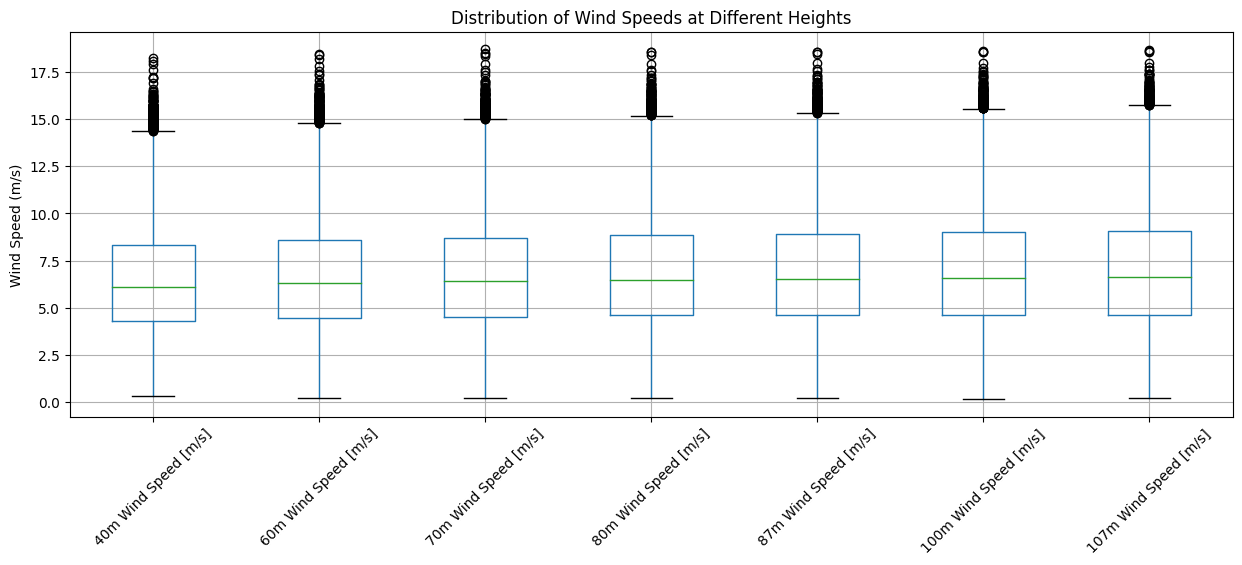

NaN values in data: 115765
Infinite values in data: 0


Sparrow Search Progress:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict
import random
from torch.cuda.amp import autocast, GradScaler
import logging
from IPython.display import display, HTML
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
def set_seeds(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seeds(42)

# Configuration
CONFIG = {
    'input_size': 16,  # Updated to include temporal features (6 wind speeds + 10 temporal features)
    'sequence_length': 10,
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 100,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'train_size': 0.7,
    'val_size': 0.15,
    'test_size': 0.15
}

print(f"Using device: {CONFIG['device']}")

class WindSpeedDataset(Dataset):
    def __init__(self, data: np.ndarray, sequence_length: int):
        self.data = torch.FloatTensor(data)
        self.sequence_length = sequence_length
        
    def __len__(self) -> int:
        return len(self.data) - self.sequence_length
        
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.data[idx:idx + self.sequence_length, :-1]
        y = self.data[idx + self.sequence_length - 1, -1]
        return x, y

def preprocess_data(data: pd.DataFrame) -> Tuple[np.ndarray, MinMaxScaler]:
    """
    Preprocess the data with both scaling and temporal features
    """
    # Convert Date/Time column to datetime
    data['Date/Time'] = pd.to_datetime(data['Date/Time'])
    
    # Extract temporal features
    data['hour'] = data['Date/Time'].dt.hour
    data['minute'] = data['Date/Time'].dt.minute
    data['day'] = data['Date/Time'].dt.day
    data['month'] = data['Date/Time'].dt.month
    data['day_of_week'] = data['Date/Time'].dt.dayofweek
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
    
    # Create cyclical features for time
    data['hour_sin'] = np.sin(2 * np.pi * data['hour']/24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour']/24)
    data['minute_sin'] = np.sin(2 * np.pi * data['minute']/60)
    data['minute_cos'] = np.cos(2 * np.pi * data['minute']/60)
    
    # Drop original Date/Time column
    data = data.drop(['Date/Time'], axis=1)
    
    # Convert all numeric columns to float64
    numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
    data[numeric_columns] = data[numeric_columns].astype('float64')
    
    # Check for NaN values first
    if data.isna().any().any():
        logger.warning("Found NaN values in the data. Replacing with mean values.")
        data = data.fillna(data.mean())
    
    # Check for infinite values column by column
    has_inf = False
    for col in numeric_columns:
        mask = ~np.isfinite(data[col])
        if mask.any():
            has_inf = True
            mean_value = data[col][np.isfinite(data[col])].mean()
            data.loc[mask, col] = mean_value
    
    if has_inf:
        logger.warning("Found infinite values in the data. Replaced with column means.")
    
    # First apply MinMax scaling
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Apply statistical normalization
    mean = np.mean(scaled_data, axis=0)
    std = np.std(scaled_data, axis=0)
    normalized_data = (scaled_data - mean) / (std + 1e-8)
    
    return normalized_data, scaler

def analyze_temporal_patterns(data: pd.DataFrame):
    """
    Analyze and visualize temporal patterns in the wind speed data
    """
    data['Date/Time'] = pd.to_datetime(data['Date/Time'])
    
    # Hourly patterns
    plt.figure(figsize=(15, 5))
    hourly_avg = data.groupby(data['Date/Time'].dt.hour)['100m Wind Speed [m/s]'].mean()
    plt.plot(hourly_avg.index, hourly_avg.values)
    plt.title('Average Wind Speed by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Wind Speed (m/s)')
    plt.show()
    
    # Daily patterns
    plt.figure(figsize=(15, 5))
    daily_avg = data.groupby(data['Date/Time'].dt.day)['100m Wind Speed [m/s]'].mean()
    plt.plot(daily_avg.index, daily_avg.values)
    plt.title('Average Wind Speed by Day')
    plt.xlabel('Day of Month')
    plt.ylabel('Wind Speed (m/s)')
    plt.show()
    
    # Weekly patterns
    plt.figure(figsize=(15, 5))
    weekly_avg = data.groupby(data['Date/Time'].dt.dayofweek)['100m Wind Speed [m/s]'].mean()
    plt.plot(weekly_avg.index, weekly_avg.values)
    plt.title('Average Wind Speed by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Wind Speed (m/s)')
    plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.show()

class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Add batch normalization for input
        self.input_bn = nn.BatchNorm1d(input_size)
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Add batch normalization after LSTM
        self.hidden_bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
        
        # Initialize weights properly
        self._init_weights()
        
    # def _init_weights(self):
    #     for name, param in self.named_parameters():
    #         if 'weight' in name:
    #             nn.init.xavier_normal_(param)
    #         elif 'bias' in name:
    #             nn.init.constant_(param, 0.0)
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() > 1:  # Apply Xavier only to weight matrices
                nn.init.xavier_normal_(param)
            elif 'bias' in name:  # Bias initialization remains unchanged
                nn.init.constant_(param, 0.0)

                
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Add gradient clipping for stability
        for param in self.parameters():
            if param.grad is not None:
                torch.nn.utils.clip_grad_norm_(param, max_norm=1.0)
                
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # Apply input batch normalization
        x_reshaped = x.view(-1, x.size(-1))
        x_bn = self.input_bn(x_reshaped)
        x = x_bn.view(batch_size, seq_len, -1)
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # Apply LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Apply batch normalization on the output features
        last_output = out[:, -1, :]
        normalized_output = self.hidden_bn(last_output)
        
        # Apply final linear layer
        out = self.fc(normalized_output)
        
        return out.squeeze()

class SparrowSearch:
    def __init__(self, n_particles: int, max_iter: int, param_bounds: Dict):
        self.n_particles = n_particles
        self.max_iter = max_iter
        self.param_bounds = param_bounds
        self.best_solution = None
        self.best_fitness = float('inf')
        self.history = []
        
        # Initialize best_solution with middle values from param bounds
        self.best_solution = {}
        for param, (low, high) in self.param_bounds.items():
            if isinstance(low, int) and isinstance(high, int):
                self.best_solution[param] = (low + high) // 2
            else:
                self.best_solution[param] = (low + high) / 2
                
    def initialize_population(self) -> List[Dict]:
        population = []
        for i in range(self.n_particles):
            particle = {}
            for param, (low, high) in self.param_bounds.items():
                if isinstance(low, int) and isinstance(high, int):
                    particle[param] = random.randint(low, high)
                else:
                    particle[param] = random.uniform(low, high)
            population.append(particle)
        return population
        
    def update_position(self, particle: Dict, r2: float, alarm_value: float) -> Dict:
        new_particle = particle.copy()
        for param, (low, high) in self.param_bounds.items():
            if random.random() < alarm_value:
                # Random exploration
                if isinstance(low, int) and isinstance(high, int):
                    new_particle[param] = random.randint(low, high)
                else:
                    new_particle[param] = random.uniform(low, high)
            else:
                # Move towards best solution
                step = r2 * (self.best_solution[param] - particle[param])
                new_value = particle[param] + step
                if isinstance(low, int) and isinstance(high, int):
                    new_value = int(round(new_value))
                new_particle[param] = max(low, min(high, new_value))
        return new_particle
        
    def optimize(self, fitness_func) -> Tuple[Dict, float]:
        population = self.initialize_population()
        self.history = []
        
        # Add tqdm progress bar
        pbar = tqdm(range(self.max_iter), desc='Sparrow Search Progress')
        
        for iteration in pbar:
            alarm_value = 0.5 - (0.5 * iteration / self.max_iter)
            
            # Evaluate fitness for each particle in population
            iteration_best_fitness = float('inf')
            iteration_best_particle = None
            
            for i, particle in enumerate(population):
                fitness = fitness_func(particle)
                
                # Skip if fitness is NaN and keep the old particle
                if np.isnan(fitness):
                    logger.warning(f"NaN fitness detected for particle {i}. Skipping update.")
                    continue
                
                # Update iteration best
                if fitness < iteration_best_fitness:
                    iteration_best_fitness = fitness
                    iteration_best_particle = particle.copy()
                
                # Update global best
                if fitness < self.best_fitness:
                    self.best_fitness = fitness
                    self.best_solution = particle.copy()
                    pbar.set_postfix({'Best Fitness': f'{self.best_fitness:.6f}'})
            
            # Update population positions based on current best
            if iteration_best_particle is not None:
                r2 = random.random()
                population = [self.update_position(p, r2, alarm_value) for p in population]
                self.history.append(self.best_fitness)
                logger.info(f"Iteration {iteration + 1}/{self.max_iter}, Best fitness: {self.best_fitness:.6f}")
            else:
                logger.warning(f"No valid fitness found in iteration {iteration + 1}. Skipping position updates.")
                
        # Plot optimization history
        if self.history:
            plt.figure(figsize=(10, 5))
            plt.plot(self.history)
            plt.title('Sparrow Search Optimization History')
            plt.xlabel('Iteration')
            plt.ylabel('Best Fitness')
            plt.show()
            
        return self.best_solution, self.best_fitness

def create_train_val_test_split(
    scaled_data: np.ndarray,
    sequence_length: int,
    batch_size: int,
    train_size: float = 0.7,
    val_size: float = 0.15
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Split the data into training, validation, and test sets
    """
    # Calculate sizes
    n = len(scaled_data)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    
    # Split the data
    train_data = scaled_data[:train_end]
    val_data = scaled_data[train_end:val_end]
    test_data = scaled_data[val_end:]
    
    # Create datasets
    train_dataset = WindSpeedDataset(train_data, sequence_length)
    val_dataset = WindSpeedDataset(val_data, sequence_length)
    test_dataset = WindSpeedDataset(test_data, sequence_length)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    logger.info(f"Data split: Train {len(train_dataset)}, Validation {len(val_dataset)}, Test {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader

def train_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str,
    scaler: GradScaler
) -> float:
    """Train for one epoch and return average loss"""
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch_x, batch_y in data_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass with mixed precision
        with autocast():
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            # Skip batch if loss is NaN
            if torch.isnan(loss):
                logger.warning("NaN loss detected during training. Skipping batch.")
                continue
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        
        # Clip gradients for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights with scaler
        scaler.step(optimizer)
        scaler.update()
        
        # Accumulate loss
        total_loss += loss.item()
        num_batches += 1
    
    # Return average loss
    return total_loss / max(num_batches, 1)

def validate(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    device: str
) -> float:
    """Validate model and return average loss"""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            # Skip batch if loss is NaN
            if torch.isnan(loss):
                logger.warning("NaN loss detected during validation. Skipping batch.")
                continue
                
            total_loss += loss.item()
            num_batches += 1
    
    # Return average loss
    return total_loss / max(num_batches, 1)

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str,
    epochs: int,
    early_stopping_patience: int = 10
) -> Dict[str, List[float]]:
    """Train model with early stopping"""
    model = model.to(device)
    scaler = GradScaler()
    history = {'train_loss': [], 'val_loss': []}
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Train one epoch
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        
        # Validate
        val_loss = validate(model, val_loader, criterion, device)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Check for NaN loss
        if np.isnan(train_loss) or np.isnan(val_loss):
            logger.warning(f"NaN loss detected at epoch {epoch+1}. "
                          f"Train loss: {train_loss}, Val loss: {val_loss}")
            
            # Reset optimizer state and adjust learning rate
            optimizer = torch.optim.Adam(
                model.parameters(), 
                lr=optimizer.param_groups[0]['lr'] * 0.5
            )
            continue
        
        # Log progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            logger.info(f"Epoch [{epoch+1}/{epochs}], "
                      f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                logger.info(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    return history

def fitness_function(params, train_loader, val_loader):
    """Fitness function for Sparrow Search optimization"""
    logger.info(f"Evaluating parameters: {params}")
    
    try:
        # Initialize model with parameters
        model = LSTM(
            input_size=CONFIG['input_size'],
            hidden_size=int(params['hidden_size']),
            num_layers=int(params['num_layers']),
            dropout=params['dropout']
        ).to(CONFIG['device'])
        
        # Initialize optimizer and criterion
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        criterion = nn.MSELoss()
        
        # Do a quick evaluation with 5 epochs
        history = train_model(
            model, train_loader, val_loader,
            criterion, optimizer,
            CONFIG['device'], epochs=5
        )
        
        # Get final validation loss
        final_loss = history['val_loss'][-1]
        
        # Check for NaN or infinite loss
        if np.isnan(final_loss) or np.isinf(final_loss):
            logger.warning(f"Invalid loss value: {final_loss}. Returning high penalty.")
            return 1e6
        
        logger.info(f"Evaluation complete. Loss: {final_loss:.6f}")
        return final_loss
        
    except Exception as e:
        logger.error(f"Error in fitness evaluation: {str(e)}")
        return 1e6

def evaluate_model(
    model: nn.Module,
    data_loader: DataLoader,
    target_scaler: MinMaxScaler,
    target_idx: int,
    device: str
) -> Dict[str, float]:
    """Evaluate model on test set and return metrics"""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())
    
    # Create dummy arrays for inverse transform
    pred_dummy = np.zeros((len(predictions), target_scaler.scale_.shape[0]))
    actual_dummy = np.zeros((len(actuals), target_scaler.scale_.shape[0]))
    
    # Set target column
    pred_dummy[:, target_idx] = np.array(predictions).flatten()
    actual_dummy[:, target_idx] = np.array(actuals).flatten()
    
    # Inverse transform
    pred_transformed = target_scaler.inverse_transform(pred_dummy)[:, target_idx]
    actual_transformed = target_scaler.inverse_transform(actual_dummy)[:, target_idx]
    
    # Calculate metrics
    metrics = {
        'mse': mean_squared_error(actual_transformed, pred_transformed),
        'mae': mean_absolute_error(actual_transformed, pred_transformed),
        'rmse': np.sqrt(mean_squared_error(actual_transformed, pred_transformed)),
        'r2': r2_score(actual_transformed, pred_transformed)
    }
    
    # Plot predictions vs actuals
    plt.figure(figsize=(12, 6))
    plt.scatter(actual_transformed, pred_transformed, alpha=0.5)
    plt.plot([min(actual_transformed), max(actual_transformed)], 
             [min(actual_transformed), max(actual_transformed)], 'r--')
    plt.xlabel('Actual Wind Speed')
    plt.ylabel('Predicted Wind Speed')
    plt.title('Predictions vs Actuals')
    plt.show()
    
    return metrics

def run_wind_speed_modeling():
    """Main function to run the wind speed modeling pipeline"""
    # Load data
    data = pd.read_csv('/kaggle/input/ws-data/ws_data.csv')
    display(data.head())
    print("\nData shape:", data.shape)
    
    # Plot input features distribution
    plt.figure(figsize=(15, 5))
    data.boxplot()
    plt.title('Distribution of Wind Speeds at Different Heights')
    plt.ylabel('Wind Speed (m/s)')
    plt.xticks(rotation=45)
    plt.show()
    
    # Check for NaN or infinite values
    numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
    print("NaN values in data:", data.isna().sum().sum())
    print("Infinite values in data:", data[numeric_columns].apply(lambda x: np.isinf(x).sum()).sum())

    # Preprocess data
    scaled_data, scaler = preprocess_data(data)
    
    # Create train, validation, and test splits
    train_loader, val_loader, test_loader = create_train_val_test_split(
        scaled_data,
        CONFIG['sequence_length'],
        CONFIG['batch_size'],
        CONFIG['train_size'],
        CONFIG['val_size']
    )
    
    # Define parameter bounds for Sparrow Search
    param_bounds = {
        'hidden_size': (32, 128),
        'num_layers': (25, 50),
        'dropout': (0.1, 0.5),
        'learning_rate': (0.0005, 0.005)
    }
    
    # Create fitness function with fixed train/val loaders
    def search_fitness(params):
        return fitness_function(params, train_loader, val_loader)
    
    # Initialize and run Sparrow Search
    sparrow = SparrowSearch(n_particles=100, max_iter=10, param_bounds=param_bounds)
    best_params, best_fitness = sparrow.optimize(search_fitness)
    
    print("\nBest parameters found:", best_params)
    print("Best fitness:", best_fitness)
    
    # Train vanilla LSTM
    vanilla_lstm = LSTM(
        input_size=CONFIG['input_size'],
        hidden_size=64,
        num_layers=25,
        dropout=0.2
    )
    
    vanilla_optimizer = torch.optim.Adam(vanilla_lstm.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    print("\nTraining vanilla LSTM...")
    vanilla_history = train_model(
        vanilla_lstm, train_loader, val_loader,
        criterion, vanilla_optimizer,
        CONFIG['device'], CONFIG['epochs']
    )
    
    # Train optimized LSTM
    optimized_lstm = LSTM(
        input_size=CONFIG['input_size'],
        hidden_size=int(best_params['hidden_size']),
        num_layers=int(best_params['num_layers']),
        dropout=best_params['dropout']
    )
    
    optimized_optimizer = torch.optim.Adam(
        optimized_lstm.parameters(),
        lr=best_params['learning_rate']
    )
    
    print("\nTraining optimized LSTM...")
    optimized_history = train_model(
        optimized_lstm, train_loader, val_loader,
        criterion, optimized_optimizer,
        CONFIG['device'], CONFIG['epochs']
    )
    
    # Evaluate models on test set
    target_idx = -1  # Assuming the target is the last column
    
    print("\nVanilla LSTM Metrics:")
    vanilla_metrics = evaluate_model(
        vanilla_lstm, test_loader, scaler, target_idx, CONFIG['device']
    )
    for metric, value in vanilla_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nOptimized LSTM Metrics:")
    optimized_metrics = evaluate_model(
        optimized_lstm, test_loader, scaler, target_idx, CONFIG['device']
    )
    for metric, value in optimized_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Plot training history comparison
    plt.figure(figsize=(12, 6))
    plt.plot(vanilla_history['val_loss'], label='Vanilla LSTM', alpha=0.8)
    plt.plot(optimized_history['val_loss'], label='Optimized LSTM', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Training History Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'vanilla_metrics': vanilla_metrics,
        'optimized_metrics': optimized_metrics,
        'best_params': best_params
    }

# Run the entire modeling pipeline
if __name__ == "__main__":
    results = run_wind_speed_modeling()